# Dask Array

### What is Dask Array?
- Dask Array is composed of many NumPy or NumPy-like arrays (e.g. CuPy arrays) under the hood
- Dask Array implements a subset of the NumPy ndarray API using blocked algorithms
- These array may be streamed out of the disk of a single computer or multiple/distributed computers
- Dask Array uses the threaded scheduler in order to avoid data transfer costs, and because NumPy releases the GIL well

**Summary**: Dask arrays include many NumPy arrays which are loaded lazily and in parallel across parallel hardware.

Source: https://docs.dask.org/en/latest/array.html

<img src="../images/dask-array-black-text.svg" width="600" height="200" style="border-style: solid;">

In [1]:
import numpy as np

from dask.distributed import Client
import dask.dataframe as dd

#### Create a Dask Client connecting to the LocalCluster

In [2]:
client = Client(n_workers=10, threads_per_worker=1, memory_limit='2GB')

client

Client Scheduler: tcp://127.0.0.1:46325 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 10 Memory: 20.00 GB


#### Read the data from the Data from multiple CSV files into a Dask DataFrame

In [3]:
# DATA_DIR = "../data/train"
DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/train"

In [4]:
# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

dd_sample_small = dd.read_csv(urlpath=f"{DATA_DIR}/1403*.csv", blocksize=None, dtype=data_types)

#### Create a Dask Array

Creating a Dask Array from a Dask DataFrame

In [5]:
da = dd_sample_small.to_dask_array(lengths=True)

da

dask.array<values, shape=(360006, 10), dtype=float32, chunksize=(60001, 10), chunktype=numpy.ndarray>

In [6]:
print(f"Shape of the Dask Array: {da.shape}")
print(f"Number of chunks: {da.npartitions}")
print(f"Type of the data inside the array: {da.dtype}")

Shape of the Dask Array: (360006, 10)
Number of chunks: 6
Type of the data inside the array: float32


In [7]:
print(f"Shape of the Chunk {da.chunksize}")

Shape of the Chunk (60001, 10)


In [8]:
print(f"Shape of the Chunk {da.chunks}")

Shape of the Chunk ((60001, 60001, 60001, 60001, 60001, 60001), (10,))


#### Deep dive into `chunks`
- This Dask Array is composed of 6 NumPy Arrays each having a shape (60001, 10)
- Dask Array stores the size of each block (NumPy Array) along each axis using a tuple of tuples
- Length of the outer tuple is equal to the number of dimensions of the array (In this case 2)
- Lengths of the inner tuples are equal to the number of blocks (NumPy Arrays) along each dimension
    - For dimenesion 1, it is 6.
    - For dimension 2, it is 1.

<img src="../images/Dask_Array_Chunks.png" width="600" height="200" style="border-style: solid;">

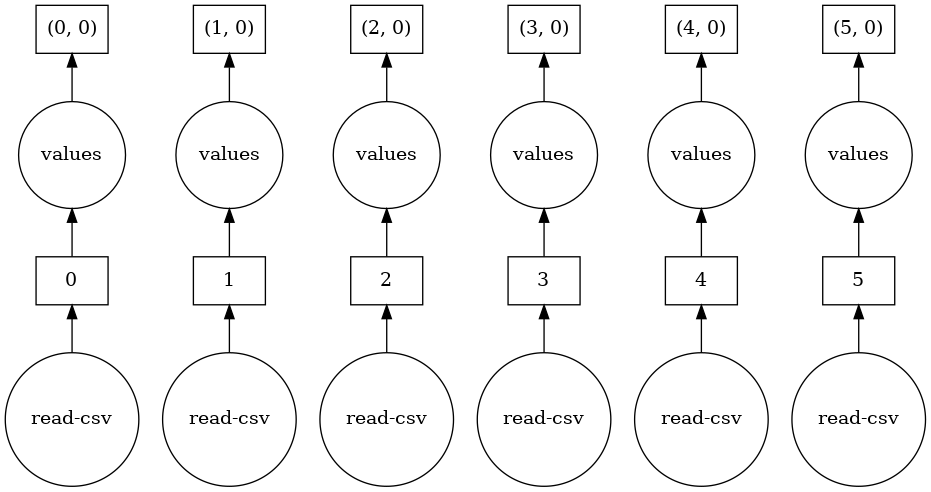

In [9]:
da.visualize()

#### Dask arrays support **most** of the NumPy interface like the following:
- Arithmetic and scalar mathematics: +, *, exp, log, ...
- Reductions along axes: sum(), mean(), std(), sum(axis=0), ...
- Tensor contractions / dot products / matrix multiply: tensordot
- Axis reordering / transpose: transpose
- Slicing: x[:100, 500:100:-2]
- Fancy indexing along single axes with lists or NumPy arrays: x[:, [10, 1, 5]]
- Array protocols like __array__ and __array_ufunc__
- Some linear algebra: svd, qr, solve, solve_triangular, lstsq
    
#### Blocked Algorithms
- Dask Arrays are implemented using blocked algorithms
- These algorithms break up a computation on a large array into many computations on smaller pieces of the array
- As a result, data can be loaded from the disk to the main memory (RAM) on the need basis

### Slice the Array

In [10]:
da[60000:60010, 1:3]

dask.array<getitem, shape=(10, 2), dtype=float32, chunksize=(9, 2), chunktype=numpy.ndarray>

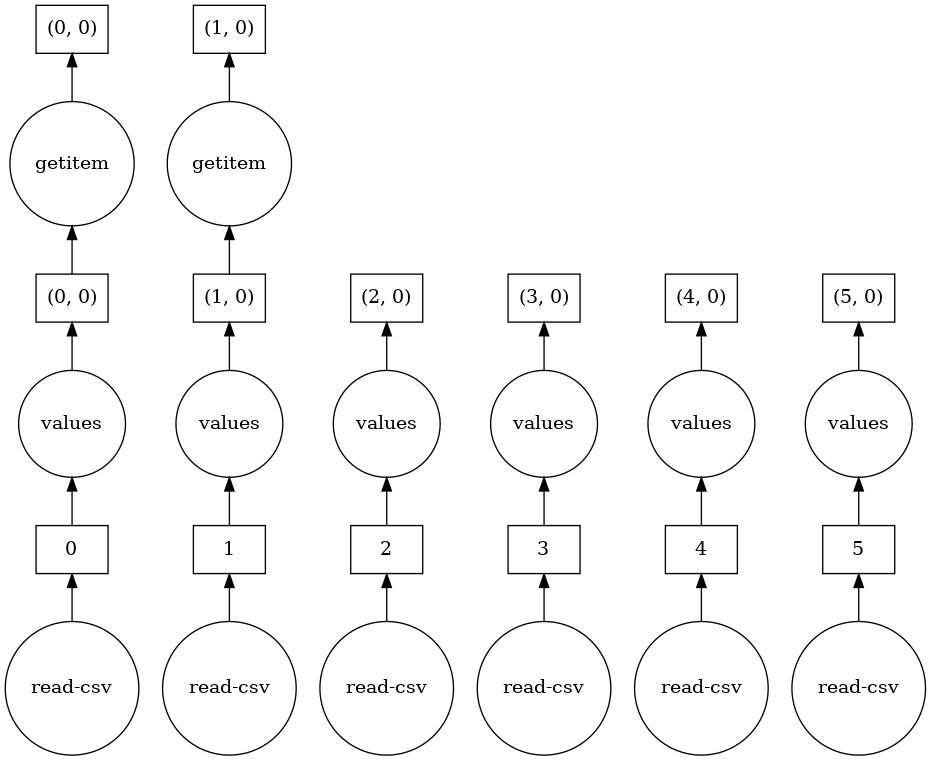

In [11]:
da[60000:60010, 1:3].visualize()

In [12]:
da[60000:60010, 1:3].compute()

array([[ -172.,    92.],
       [-1285.,   466.],
       [-1172.,   436.],
       [-1000.,   443.],
       [ -821.,   410.],
       [ -667.,   359.],
       [ -452.,   297.],
       [ -213.,   175.],
       [  146.,    87.],
       [  570.,    22.]], dtype=float32)

#### Compute Mean of a slice

In [13]:
da[60000:60010, 1:3].mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

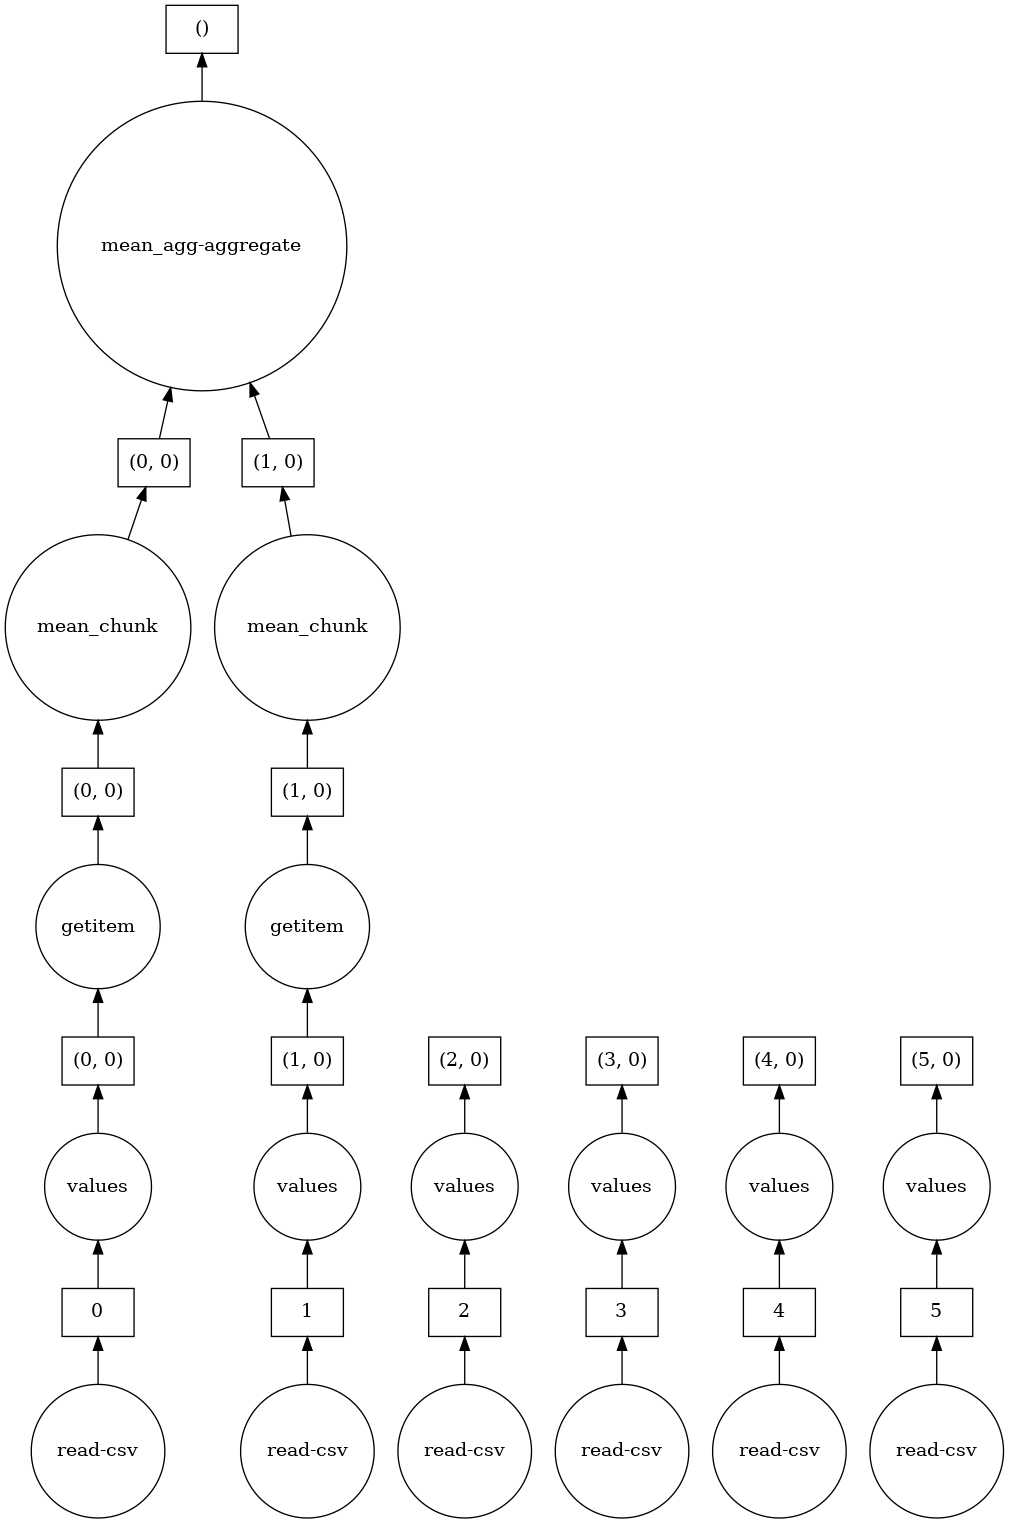

In [14]:
da[60000:60010, 1:3].mean().visualize()

In [15]:
da[60000:60010, 1:3].mean().compute()

-113.95

In [16]:
type(da[60000:60010, 1:3].mean().compute())

numpy.float32

#### Close the Dask Client

In [17]:
client.close()